In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Skipping, found downloaded files in ".\bean-leaf-lesions-classification" (use force=True to force download)


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

In [4]:
device

'cuda'

In [5]:
train_df = pd.read_csv("bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()
     

Data shape is:  (1167, 2)



,image:FILE,category
0,bean-leaf-lesions-classification/train/healthy...,0
1,bean-leaf-lesions-classification/train/healthy...,0
2,bean-leaf-lesions-classification/train/healthy...,0
3,bean-leaf-lesions-classification/train/healthy...,0
4,bean-leaf-lesions-classification/train/healthy...,0


In [6]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())

Classes are: 
[0 1 2]

Classes ditrubution are: 
category
2    393
1    389
0    385
Name: count, dtype: int64


In [7]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

In [8]:
label_encoder = LabelEncoder() # Encode the string classes to numeric

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float), # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)
     

In [9]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image, label

In [10]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

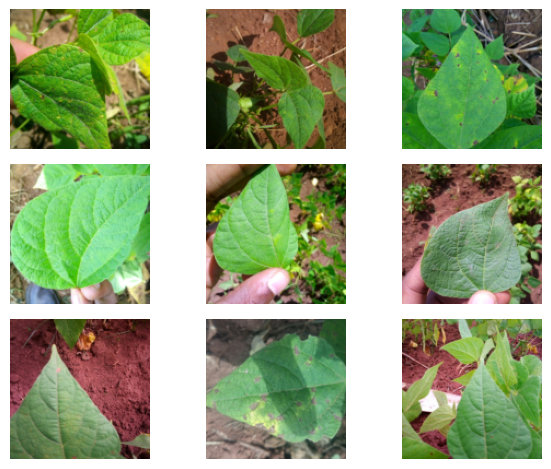

In [11]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [21]:
LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 15

In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

In [24]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [25]:

num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=LR) # Adam optimizer

In [27]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()

Epoch 1/15, Train Loss: 0.3909 Train Accuracy 66.3403%

Epoch 2/15, Train Loss: 0.2502 Train Accuracy 80.4162%

Epoch 3/15, Train Loss: 0.2864 Train Accuracy 78.3354%

Epoch 4/15, Train Loss: 0.1839 Train Accuracy 86.2913%

Epoch 5/15, Train Loss: 0.2384 Train Accuracy 82.8641%

Epoch 6/15, Train Loss: 0.2206 Train Accuracy 82.7417%

Epoch 7/15, Train Loss: 0.1921 Train Accuracy 87.7601%

Epoch 8/15, Train Loss: 0.1621 Train Accuracy 88.1273%

Epoch 9/15, Train Loss: 0.1398 Train Accuracy 91.4321%

Epoch 10/15, Train Loss: 0.1104 Train Accuracy 91.7993%

Epoch 11/15, Train Loss: 0.1769 Train Accuracy 89.4737%

Epoch 12/15, Train Loss: 0.1237 Train Accuracy 93.1457%

Epoch 13/15, Train Loss: 0.1057 Train Accuracy 93.0233%

Epoch 14/15, Train Loss: 0.1434 Train Accuracy 93.1457%

Epoch 15/15, Train Loss: 0.0971 Train Accuracy 94.2472%



In [28]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 82.57%


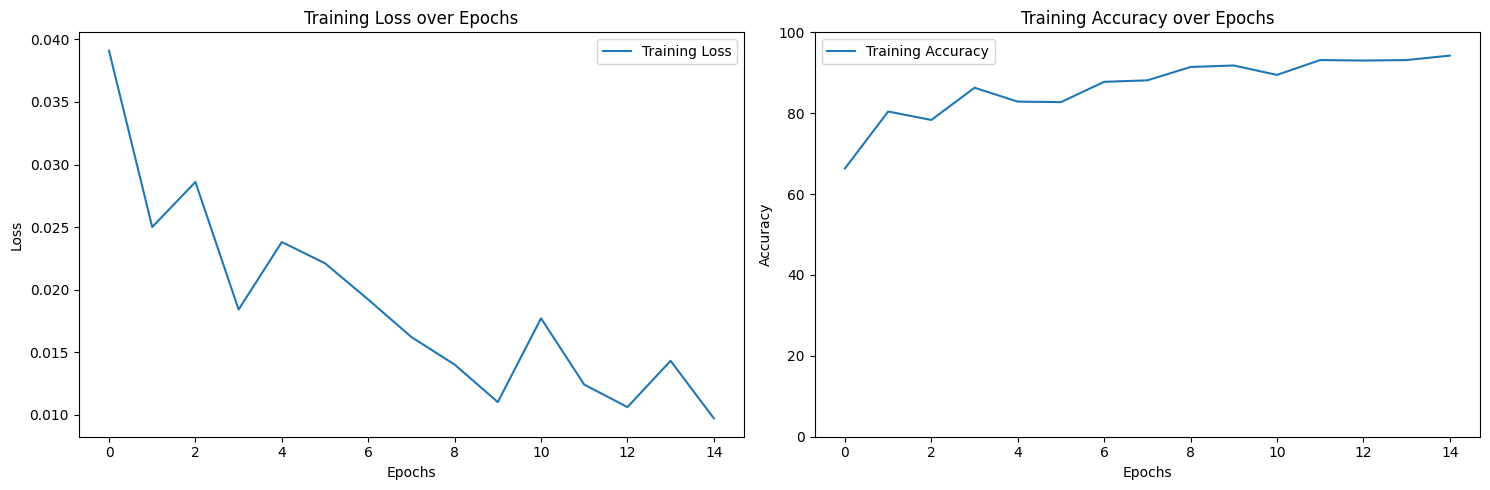

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()